In [1]:
import pickle
import numpy as np
import matplotlib.pylab as plt
import uproot
from sklearn.metrics import confusion_matrix

In [2]:
def return_accuracy(predict1,predict2,validation):
    mass_predict1 = []
    for i in predict1:
        if i <2.5:
            mass_predict1.append(1)
        else:
            mass_predict1.append(4)
    cm=confusion_matrix(validation,mass_predict1)

    mass_predict4 = []
    for i in predict2:
        if i <2.5:
            mass_predict4.append(1)
        else:
            mass_predict4.append(4)
    cm1=confusion_matrix(validation,mass_predict4)
    
    return cm[0][0]/np.sum(cm[0]),cm1[1][1]/np.sum(cm1[1]),np.array(mass_predict1),np.array(mass_predict4)

In [3]:
file = uproot.open('/home/andy/12360.root')
file2 = uproot.open('/home/andy/12362.root')

In [4]:
cut_model = pickle.load((open('cut_model.sav','rb')))
proton_model =  pickle.load((open('proton_best_model.sav','rb')))
iron_model =  pickle.load((open('iron_best_model.sav','rb')))

In [5]:
S125_1 = np.log10(file['LaputopParams']['s125'].array())
S125_2 = np.log10(file2['LaputopParams']['s125'].array())
A1 = file['CurvatureOnlyParams']['A'].array()
A2 = file2['CurvatureOnlyParams']['A'].array()
D1 = file['CurvatureOnlyParams']['D'].array()
D2 = file2['CurvatureOnlyParams']['D'].array()
beta1 = file['LaputopParams']['beta'].array()
beta2 = file2['LaputopParams']['beta'].array()
zenith1 = file['Laputop']['zenith'].array()
zenith2 = file2['Laputop']['zenith'].array()
chi2_1 = file['CurvatureOnlyParams']['chi2_time'].array()
chi2_2 = file2['CurvatureOnlyParams']['chi2_time'].array()
energy1 = file['MCPrimary']['energy'].array()
energy2 = file2['MCPrimary']['energy'].array()
mass1 = [1 for i in range(len(energy1))]
mass2 = [4 for i in range(len(energy2))]

In [6]:
A = np.append(A1,A2)
D = np.append(D1,D2)
S125 = np.append(S125_1,S125_2)
beta = np.log10(np.append(beta1,beta2))
chi2 = np.log10(np.append(chi2_1,chi2_2))
zenith = np.cos(np.append(zenith1,zenith2))
zenith_new = np.append(zenith1,zenith2)*180/np.pi
mass = np.append(mass1,mass2)
energy = np.append(energy1,energy2)

In [7]:
mask = cut_model.predict(list(zip(S125,A,zenith,chi2)))

In [8]:
mask_new = []
for i in mask:
    if i < 0.5:
        mask_new.append(False)
    else:
        mask_new.append(True)

In [9]:
input_variable2_old = np.array([np.append(i,j) for i,j in zip(D[mask_new],beta[mask_new])])
output_new_old = mass[mask_new]
energy_new = zenith_new[mask_new]

import random
validation_x = []
validation_y = []
input_variable2 = []
output_new = []
validation_energy = []

for i in range(len(input_variable2_old)):
    if random.random() < 0.1:
        validation_x.append(input_variable2_old[i])
        validation_y.append(output_new_old[i])
        validation_energy.append(energy_new[i])
    else:
        input_variable2.append(input_variable2_old[i])
        output_new.append(output_new_old[i])

In [10]:
from sklearn.model_selection import train_test_split
seed = 7
test_size = 0.2
X_train, X_test, y_train_1, y_test_1 = train_test_split(input_variable2,output_new , test_size=test_size, random_state=seed)

In [11]:
prediction1 = proton_model.predict(X_train)
prediction2 = iron_model.predict(X_train)
print(return_accuracy(prediction1,prediction2,y_train_1))

(0.954890613501037, 0.9144546998751611, array([1, 1, 1, ..., 1, 1, 1]), array([1, 4, 4, ..., 4, 4, 1]))


In [12]:
prediction1 = proton_model.predict(X_test)
prediction2 = iron_model.predict(X_test)
print(return_accuracy(prediction1,prediction2,y_test_1))

(0.9547893748323047, 0.9140758873929009, array([1, 1, 1, ..., 1, 1, 1]), array([4, 1, 1, ..., 4, 1, 4]))


In [13]:
prediction1 = proton_model.predict(validation_x)
prediction2 = iron_model.predict(validation_x)
print(return_accuracy(prediction1,prediction2,validation_y))

(0.9558125380401704, 0.9146890958245719, array([1, 1, 1, ..., 1, 1, 1]), array([1, 1, 4, ..., 4, 4, 4]))


In [14]:
data1 = np.array(list(zip(validation_x,validation_y)))
data2 = np.array(np.log10(validation_energy))
array_split = np.array_split(sorted(list(zip(data1,data2)),key=lambda x:x[1]),20)

In [15]:
x = []
y_proton = []
y_iron = []
for i in array_split:
    energy = list(zip(*i))[1]
    mass = list(zip(*list(zip(*i))[0]))[1]
    data = list(zip(*list(zip(*i))[0]))[0]
    prediction1 = proton_model.predict(data)
    prediction2 = iron_model.predict(data)
    acc_proton,acc_iron,something1,something2 = return_accuracy(prediction1,prediction2,mass)
    y_proton.append(acc_proton)
    y_iron.append(acc_iron)
    x.append((max(energy)+min(energy))/2)

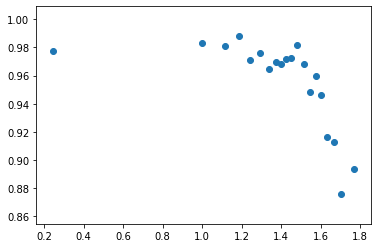

In [16]:
plt.scatter(x,y_proton)
plt.show()

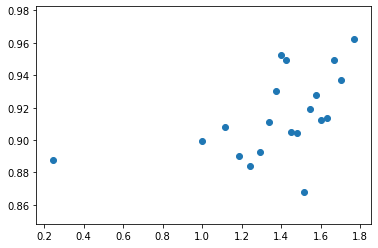

In [17]:
plt.scatter(x,y_iron)